# Аномалии

Работа с аномалиями в данных: способы нахождения, построение графиков

In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd

import scipy.stats as sts
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')  # стиль для графиков
%matplotlib inline

Анализируемые данные - датасет, содержащий информацию о мемах, собранный парсером с сайта [Know your meme](https://knowyourmeme.com/) 

In [14]:
df = pd.read_csv('C:\\Users\\ksenkys\\Прикладная статистика\\Данные\\memes_prepare.csv', sep='\t')
df.set_index('name', inplace=True)

# возьмём только числовые колонки
df = df[['views', 'photos', 'comments', 'days_from_creation', 
          'average_views', 'average_comments', 'tags_len' ]]
df.head()

,views,photos,comments,days_from_creation,average_views,average_comments,tags_len
name,,,,,,,
Muvvafukka,13613,7,8,13.478206,940.240799,0.552555,197.0
Martyrdom (Drop a Live Grenade When Killed),13973,17,8,14.139201,922.968104,0.528429,102.0
Wet Kylo Ren,5339,12,7,14.150937,352.387435,0.462018,130.0
You're Invited,2249,0,0,14.209444,147.868649,0.000000,38.0
Companies Posting Their Own Names,5662,16,33,12.118958,431.589144,2.515444,200.0


__Гистограммы по каждой переменной__

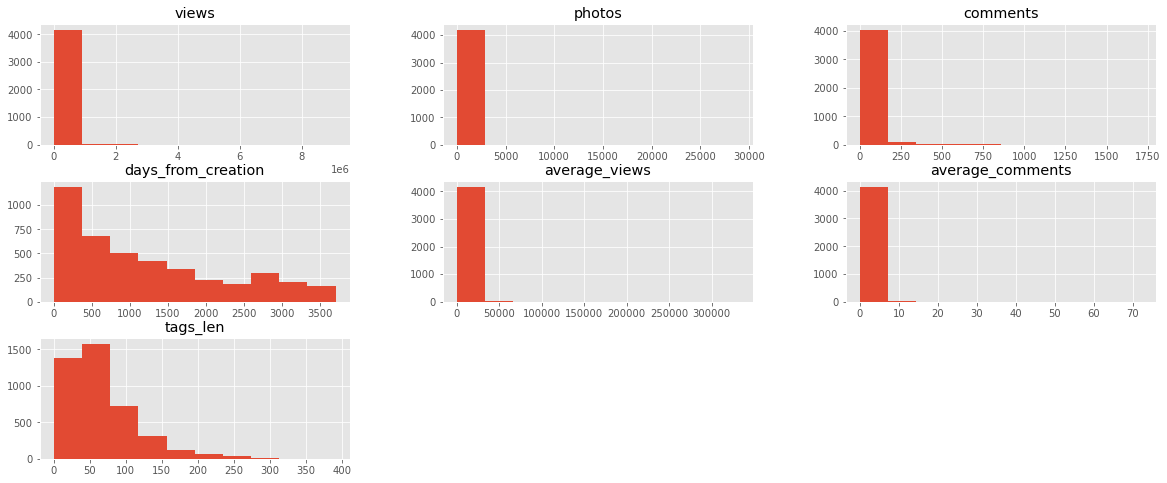

In [15]:
df.hist(figsize=(20, 8));

Прологарифмируем наши перменные, так как на гистограммах видны тяжелые хвосты

In [16]:
for var in ['views', 'photos', 'average_views', 
            'average_comments', 'comments']:
    df[var] = df[var].apply(lambda w: np.log(w + 1))

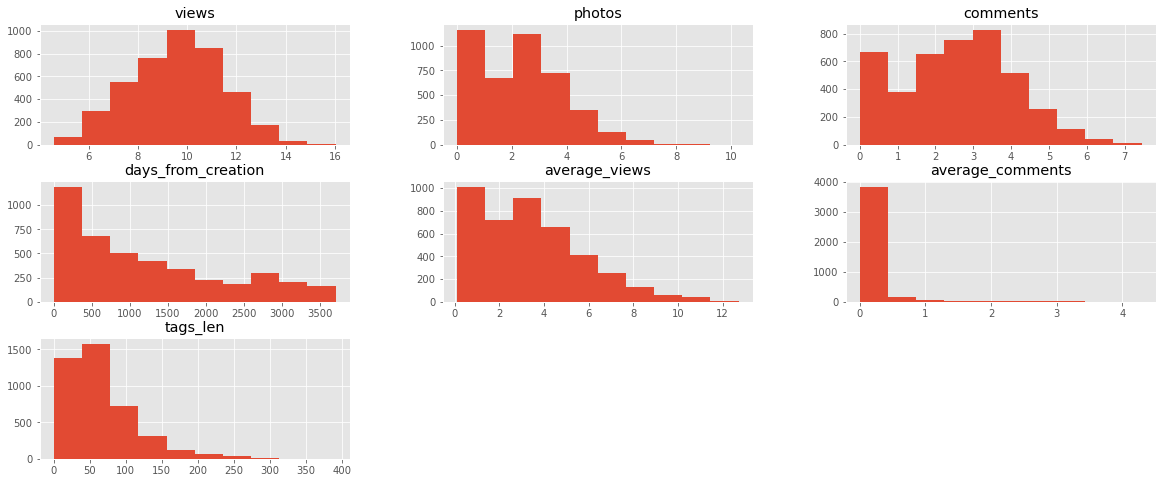

In [17]:
df.hist(figsize=(20, 8));

## Поиск аномалий

In [6]:
def outlier_std(data, col, threshold=3):
    """
        Вычисляет для каждой строки является ли она аномалией с помощью правила 3-х сигм (количество сигм можно задавать)
    """
    
    mean = data[col].mean()
    std = data[col].std()
    
    up_bound = mean + threshold * std
    low_bound = mean - threshold * std
    
    anomalies = pd.concat([data[col] > up_bound, data[col] < low_bound], axis=1).any(axis=1)
    return anomalies, up_bound, low_bound

In [7]:
a,l,r = outlier_std(df, df.columns)
l

views                   15.185193
photos                   7.225498
comments                 7.051274
days_from_creation    4313.298348
average_views           10.518375
average_comments         1.436078
tags_len               208.228516
dtype: float64

Добавим дополнительные колонки с обозначением, является ли наблюдение выбросом

In [18]:
def get_column_outliers(data, function=outlier_std, threshold=3):
    # формируем колонку аномалия/не аномалия
    # сначала содержит только фолзы по всей длине, индекс - название мема, название - is_outlier
    outliers = pd.Series(data=[False]*len(data), index=data.index, name='is_outlier')
    
    # словарь со статистикой по каждой колонке
    comparison_table = {}
    
    for column in data.columns:
        anomalies, upper_bound, lower_bound = function(data, column, threshold=threshold)
        comparison_table[column] = [upper_bound, lower_bound, sum(anomalies), 100*sum(anomalies)/len(anomalies)]
        # внутри outliers по всем индексам, где был найдена аномалия, записываем True
        outliers.loc[anomalies[anomalies].index] = True
    
    comparison_table = pd.DataFrame(comparison_table).T
    comparison_table.columns=['upper_bound', 'lower_bound', 'anomalies_count', 'anomalies_percentage']
    
    return comparison_table, outliers

Сформируем таблицу с указанием количества и доли аномалий в каждой из имеющихся перменных

In [19]:
comparison_table, std_outliers = get_column_outliers(df)
comparison_table

,upper_bound,lower_bound,anomalies_count,anomalies_percentage
views,15.185193,3.980612,2.0,0.047551
photos,7.225498,-2.782073,13.0,0.309082
comments,7.051274,-1.882095,5.0,0.118878
days_from_creation,4313.298348,-1922.649473,0.0,0.000000
average_views,10.518375,-3.710159,38.0,0.903471
average_comments,1.436078,-1.129207,116.0,2.757965
tags_len,208.228516,-77.210922,78.0,1.854494


In [20]:
std_outliers

name
Muvvafukka                                     False
Martyrdom (Drop a Live Grenade When Killed)    False
Wet Kylo Ren                                   False
You're Invited                                 False
Companies Posting Their Own Names              False
                                               ...  
In G Major                                     False
Blood Diamond Pants                            False
Because of Parkinson's                         False
Paranoid Parrot                                 True
I Believe You Have My Stapler                  False
Name: is_outlier, Length: 4206, dtype: bool

In [21]:
def anomalies_report(outliers):
    print('Total number of outliers: {}\nPercentage of outliers:   {:.2f}%'.format(sum(outliers), 100*sum(outliers)/len(outliers)))

Получаем общее количество выбросов и их процент в выборке

In [23]:
anomalies_report(std_outliers)

Total number of outliers: 197
Percentage of outliers:   4.68%


In [24]:
labeled_df = df.copy()
labeled_df['is_outlier'] = std_outliers

In [25]:
labeled_df.head()

,views,photos,comments,days_from_creation,average_views,average_comments,tags_len,is_outlier
name,,,,,,,,
Muvvafukka,9.518854,2.079442,2.197225,13.478206,6.847199,0.439902,197.0,False
Martyrdom (Drop a Live Grenade When Killed),9.544954,2.890372,2.197225,14.139201,6.828678,0.424241,102.0,False
Wet Kylo Ren,8.582981,2.564949,2.079442,14.150937,5.867565,0.379817,130.0,False
You're Invited,7.718685,0.000000,0.000000,14.209444,5.003064,0.000000,38.0,False
Companies Posting Their Own Names,8.641709,2.833213,3.526361,12.118958,6.069788,1.257166,200.0,False


__Построим графики точек и распределений для наблюдений, яляющихся аномалиями и нет__

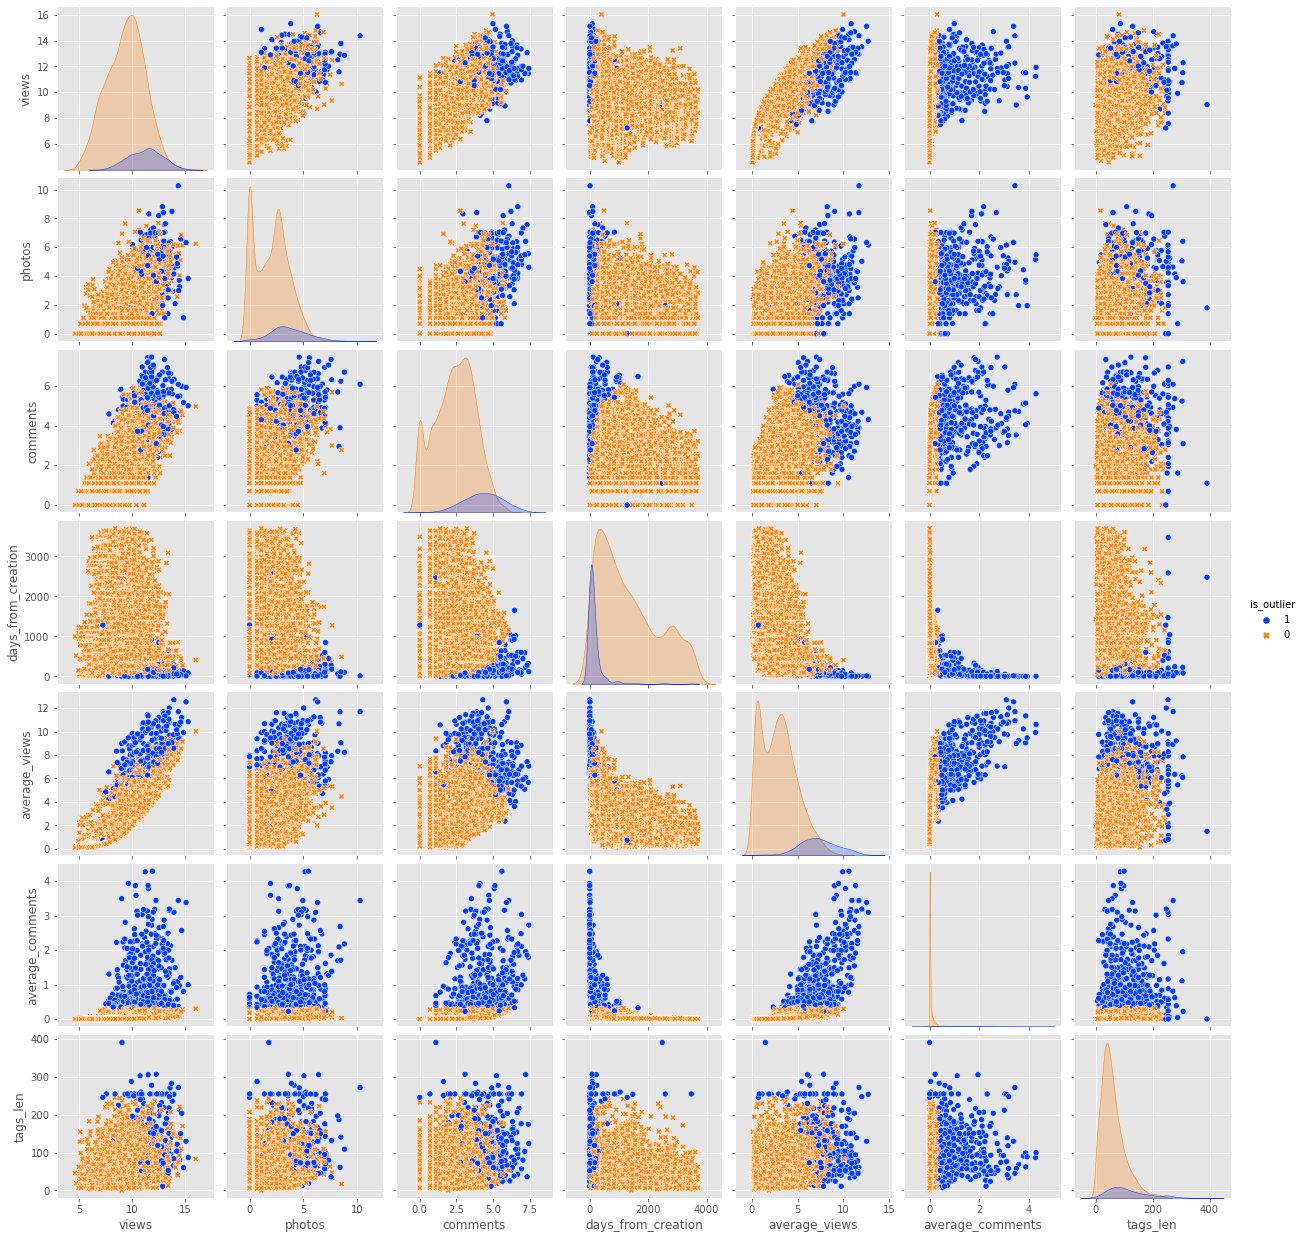

In [30]:
sns.pairplot(data=labeled_df, vars=df.columns,
            hue = 'is_outlier', hue_order=[1,0],
            markers=['X', 'o'], palette='bright');

__Функция для отбора аномалий__

In [34]:
def outliear_iqr(data, col, threshold=3):
    IQR = data[col].quantile(0.75) - data[col].quantile(0.25)
    
    up_bound = data[col].quantile(0.75)+(IQR*threshold)
    low_bound = data[col].quantile(0.25)-(IQR*threshold)
    
    anomalies = pd.concat([data[col]>up_bound, data[col]<low_bound], axis=1).any(axis=1)
    return anomalies, up_bound, low_bound

In [35]:
comparison_table, iqr_outliers = get_column_outliers(df, function=outliear_iqr)
anomalies_report(iqr_outliers)

Total number of outliers: 459
Percentage of outliers:   10.91%
